If you're opening this Notebook on colab, you will probably need to install 🤗 Transformers and 🤗 Datasets. Uncomment the following cell and run it.

In [1]:
#! pip install datasets transformers

If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your username and password:

In [2]:
# from huggingface_hub import notebook_login

# notebook_login()

Then you need to install Git-LFS. Uncomment the following instructions:

In [3]:
# !apt install git-lfs

Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version:

In [4]:
# import transformers
import sys
# sys.path.append(r'/fs/clip-quiz/amao/Github/transformers/src')
sys.path.append(r'/fs/clip-quiz/amao/Github/transformers_andrew/src')

import transformers

print(transformers.__file__)
print(transformers.__version__)

/fs/clip-quiz/amao/Github/transformers_andrew/src/transformers/__init__.py
4.13.0.dev0


You can find a script version of this notebook to fine-tune your model in a distributed fashion using multiple GPUs or TPUs [here](https://github.com/huggingface/transformers/tree/master/examples/question-answering).

# Fine-tuning a model on a question-answering task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) model to a question answering task, which is the task of extracting the answer to a question from a given context. We will see how to easily load a dataset for these kinds of tasks and use the `Trainer` API to fine-tune a model on it.

![Widget inference representing the QA task](images/question_answering.png)

**Note:** This notebook finetunes models that answer question by taking a substring of a context, not by generating new text.

This notebook is built to run on any question answering task with the same format as SQUAD (version 1 or 2), with any model checkpoint from the [Model Hub](https://huggingface.co/models) as long as that model has a version with a token classification head and a fast tokenizer (check on [this table](https://huggingface.co/transformers/index.html#bigtable) if this is the case). It might just need some small adjustments if you decide to use a different dataset than the one used here. Depending on you model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those three parameters, then the rest of the notebook should run smoothly:

In [5]:
# This flag is the difference between SQUAD v1 or 2 (if you're using another dataset, it indicates if impossible
# answers are allowed or not).
squad_v2 = False
# squad_v2 = True
# model_checkpoint = "distilbert-base-uncased"
model_checkpoint = "albert-base-v2"
batch_size = 16

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.  

In [6]:
from datasets import load_dataset, load_metric

In [7]:
from datasets import DatasetDict

For our example here, we'll use the [SQUAD dataset](https://rajpurkar.github.io/SQuAD-explorer/). The notebook should work with any question answering dataset provided by the 🤗 Datasets library. If you're using your own dataset defined from a JSON or csv file (see the [Datasets documentation](https://huggingface.co/docs/datasets/loading_datasets.html#from-local-files) on how to load them), it might need some adjustments in the names of the columns used.

In [8]:
# datasets = load_dataset("squad_v2" if squad_v2 else "squad")

train_ds,val_ds = load_dataset("squad_v2" if squad_v2 else "squad", split=['train[:10%]', 'validation[:10%]'])
datasets = DatasetDict({'train':train_ds, 'validation':val_ds})

Reusing dataset squad (/cliphomes/amao1/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 8760
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1057
    })
})

The `datasets` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set.

In [10]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 8760
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1057
    })
})

We can see the training, validation and test sets all have a column for the context, the question and the answers to those questions.

To access an actual element, you need to select a split first, then give an index:

In [11]:
datasets["train"][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

We can see the answers are indicated by their start position in the text (here at character 515) and their full text, which is a substring of the context as we mentioned above.

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset (automatically decoding the labels in passing).

In [12]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [13]:
show_random_elements(datasets["train"])

,id,title,context,question,answers
0,56bfb502a10cfb140055125c,Beyoncé,"Forbes magazine began reporting on Beyoncé's earnings in 2008, calculating that the $80 million earned between June 2007 to June 2008, for her music, tour, films and clothing line made her the world's best-paid music personality at the time, above Madonna and Celine Dion. They placed her fourth on the Celebrity 100 list in 2009 and ninth on the ""Most Powerful Women in the World"" list in 2010. The following year, Forbes placed her eighth on the ""Best-Paid Celebrities Under 30"" list, having earned $35 million in the past year for her clothing line and endorsement deals. In 2012, Forbes placed Beyoncé at number 16 on the Celebrity 100 list, twelve places lower than three years ago yet still having earned $40 million in the past year for her album 4, clothing line and endorsement deals. In the same year, Beyoncé and Jay Z placed at number one on the ""World's Highest-Paid Celebrity Couples"", for collectively earning $78 million. The couple made it into the previous year's Guinness World Records as the ""highest-earning power couple"" for collectively earning $122 million in 2009. For the years 2009 to 2011, Beyoncé earned an average of $70 million per year, and earned $40 million in 2012. In 2013, Beyoncé's endorsements of Pepsi and H&M made her and Jay Z the world's first billion dollar couple in the music industry. That year, Beyoncé was published as the fourth most-powerful celebrity in the Forbes rankings. MTV estimated that by the end of 2014, Beyoncé would become the highest-paid black musician in history; she succeeded to do so in April 2014. In June 2014, Beyoncé ranked at #1 on the Forbes Celebrity 100 list, earning an estimated $115 million throughout June 2013 – June 2014. This in turn was the first time she had topped the Celebrity 100 list as well as being her highest yearly earnings to date. As of May 2015, her net worth is estimated to be $250 million.",In 2012 who placed Beyonce at 16 in the Celebrity List?,"{'text': ['Forbes'], 'answer_start': [0]}"
1,56db410fe7c41114004b4fc6,American_Idol,"American Idol premiered in June 2002 and became the surprise summer hit show of 2002. The first show drew 9.9 million viewers, giving Fox the best viewing figure for the 8.30 pm spot in over a year. The audience steadily grew, and by finale night, the audience had averaged 23 million, with more than 40 million watching some part of that show. That episode was placed third amongst all age groups, but more importantly it led in the 18–49 demographic, the age group most valued by advertisers.",How many people watched the first episode of American Idol?,"{'text': ['9.9 million'], 'answer_start': [106]}"
2,56d971ebdc89441400fdb480,2008_Summer_Olympics_torch_relay,"\n North Korea: The event was held in Pyongyang on April 28. It was the first time that the Olympic torch has traveled to North Korea. A crowd of thousands waving pink paper flowers and small flags with the Beijing Olympics logo were organized by the authoritarian regime watched the beginning of the relay in Pyongyang, some waving Chinese flags. The event was presided over by the head of the country's parliament, Kim Yong Nam. The North, an ally of China, has been critical of disruptions to the torch relay elsewhere and has supported Beijing in its actions against protests in Tibet. Kim passed the torch to the first runner Pak Du Ik, who played on North Korea's 1966 World Cup soccer team, as he began the 19-kilometre route through Pyongyang. The relay began from the large sculpted flame of the obelisk of the Juche Tower, which commemorates the national ideology of Juche, or ""self-reliance"", created by the country's late founding President Kim Il Sung, father of leader Kim Jong Il, who did not attend.",When did the torch arrive in Pyongyang?,"{'text': ['April 28'], 'answer_start': [50]}"
3,56d10d4e17492d1400aab828,New_York_City,"The traditional New York area accent is characterized as non-rhotic, 

## Preprocessing the training data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [14]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

The following assertion ensures that our tokenizer is a fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, and we will need some of the special features they have for our preprocessing.

In [15]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

You can check which type of models have a fast tokenizer available and which don't on the [big table of models](https://huggingface.co/transformers/index.html#bigtable).

You can directly call this tokenizer on two sentences (one for the answer, one for the context):

In [16]:
tokenizer("What is your name?", "My name is Sylvain.")

{'input_ids': [2, 98, 25, 154, 204, 60, 3, 51, 204, 25, 10993, 1385, 108, 9, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

Now one specific thing for the preprocessing in question answering is how to deal with very long documents. We usually truncate them in other tasks, when they are longer than the model maximum sentence length, but here, removing part of the the context might result in losing the answer we are looking for. To deal with this, we will allow one (long) example in our dataset to give several input features, each of length shorter than the maximum length of the model (or the one we set as a hyper-parameter). Also, just in case the answer lies at the point we split a long context, we allow some overlap between the features we generate controlled by the hyper-parameter `doc_stride`:

In [17]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

Let's find one long example in our dataset:

In [18]:
for i, example in enumerate(datasets["train"]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > 384:
        break
example = datasets["train"][i]

Without any truncation, we get the following length for the input IDs:

In [19]:
len(tokenizer(example["question"], example["context"])["input_ids"])

396

Now, if we just truncate, we will lose information (and possibly the answer to our question):

In [20]:
len(tokenizer(example["question"], example["context"], max_length=max_length, truncation="only_second")["input_ids"])

384

Note that we never want to truncate the question, only the context, else the `only_second` truncation picked. Now, our tokenizer can automatically return us a list of features capped by a certain maximum length, with the overlap we talked above, we just have to tell it with `return_overflowing_tokens=True` and by passing the stride:

In [21]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)

Now we don't have one list of `input_ids`, but several: 

In [22]:
[len(x) for x in tokenized_example["input_ids"]]

[384, 157]

And if we decode them, we can see the overlap:

In [23]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

[CLS] how many wins does the notre dame men's basketball team have?[SEP] the men's basketball team has over 1,600 wins, one of only 12 schools who have reached that mark, and have appeared in 28 ncaa tournaments. former player austin carr holds the record for most points scored in a single game of the tournament with 61. although the team has never won the ncaa tournament, they were named by the helms athletic foundation as national champions twice. the team has orchestrated a number of upsets of number one ranked teams, the most notable of which was ending ucla's record 88-game winning streak in 1974. the team has beaten an additional eight number-one teams, and those nine wins rank second, to ucla's 10, all-time in wins against the top team. the team plays in newly renovated purcell pavilion (within the edmund p. joyce center), which reopened for the beginning of the 2009–2010 season. the team is coached by mike brey, who, as of the 2014–15 season, his fifteenth at notre dame, has ac

Now this will give us some work to properly treat the answers: we need to find in which of those features the answer actually is, and where exactly in that feature. The models we will use require the start and end positions of these answers in the tokens, so we will also need to to map parts of the original context to some tokens. Thankfully, the tokenizer we're using can help us with that by returning an `offset_mapping`:

In [24]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][0][:100])

[(0, 0), (0, 3), (4, 8), (9, 13), (14, 18), (19, 22), (23, 28), (29, 33), (34, 37), (37, 38), (38, 39), (40, 50), (51, 55), (56, 60), (60, 61), (0, 0), (0, 3), (4, 7), (7, 8), (8, 9), (10, 20), (21, 25), (26, 29), (30, 34), (35, 36), (35, 40), (41, 45), (45, 46), (47, 50), (51, 53), (54, 58), (59, 61), (62, 69), (70, 73), (74, 78), (79, 86), (87, 91), (92, 96), (96, 97), (98, 101), (102, 106), (107, 115), (116, 118), (119, 121), (122, 126), (127, 138), (138, 139), (140, 146), (147, 153), (154, 160), (161, 165), (166, 171), (172, 175), (176, 182), (183, 186), (187, 191), (192, 198), (199, 205), (206, 208), (209, 210), (211, 217), (218, 222), (223, 225), (226, 229), (230, 240), (241, 245), (246, 248), (248, 249), (250, 258), (259, 262), (263, 267), (268, 271), (272, 277), (278, 281), (282, 285), (286, 290), (291, 301), (301, 302), (303, 307), (308, 312), (313, 318), (319, 321), (322, 325), (326, 330), (330, 331), (332, 340), (341, 351), (352, 354), (355, 363), (364, 373), (374, 379), (37

This gives, for each index of our input IDS, the corresponding start and end character in the original text that gave our token. The very first token (`[CLS]`) has (0, 0) because it doesn't correspond to any part of the question/answer, then the second token is the same as the characters 0 to 3 of the question:

In [25]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(tokenizer.convert_ids_to_tokens([first_token_id])[0], example["question"][offsets[0]:offsets[1]])

▁how How


So we can use this mapping to find the position of the start and end tokens of our answer in a given feature. We just have to distinguish which parts of the offsets correspond to the question and which part correspond to the context, this is where the `sequence_ids` method of our `tokenized_example` can be useful:

In [26]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

It returns `None` for the special tokens, then 0 or 1 depending on whether the corresponding token comes from the first sentence past (the question) or the second (the context). Now with all of this, we can find the first and last token of the answer in one of our input feature (or if the answer is not in this feature):

In [27]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(start_position, end_position)
else:
    print("The answer is not in this feature.")

23 25


And we can double check that it is indeed the theoretical answer:

In [28]:
print(tokenizer.decode(tokenized_example["input_ids"][0][start_position: end_position+1]))
print(answers["text"][0])

over 1,600
over 1,600


For this notebook to work with any kind of models, we need to account for the special case where the model expects padding on the left (in which case we switch the order of the question and the context):

In [29]:
pad_on_right = tokenizer.padding_side == "right"

Now let's put everything together in one function we will apply to our training set. In the case of impossible answers (the answer is in another feature given by an example with a long context), we set the cls index for both the start and end position. We could also simply discard those examples from the training set if the flag `allow_impossible_answers` is `False`. Since the preprocessing is already complex enough as it is, we've kept is simple for this part.

In [30]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [31]:
features = prepare_train_features(datasets['train'][:5])

To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command. Since our preprocessing changes the number of samples, we need to remove the old columns when applying it.

In [32]:
tokenized_datasets = datasets.map(prepare_train_features, batched=True, remove_columns=datasets["train"].column_names)

Loading cached processed dataset at /cliphomes/amao1/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-297782f5dc47b08d.arrow
Loading cached processed dataset at /cliphomes/amao1/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-51967b07013334de.arrow


Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

## Fine-tuning the model

Now that our data is ready for training, we can download the pretrained model and fine-tune it. Since our task is question answering, we use the `AutoModelForQuestionAnswering` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us:

In [33]:
%load_ext autoreload
%aimport transformers
%autoreload 1

from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
# model = AutoModelForQuestionAnswering.from_pretrained('./test-squad_v2-trained-1500steps-4_gpus')
# model = AutoModelForQuestionAnswering.from_pretrained('./test-albert-base-v2-depth_12-squad_v2-trained-3_epochs-4_gpus')

comet_ml is installed but `COMET_API_KEY` is not set.
Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForQuestionAnswering: ['predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForQuestionAnswering were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['qa_outputs.b

The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define three more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [34]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    # f"{model_name}-finetuned-squad",
    f"{model_name}-finetuned-{'squad_v2' if squad_v2 else 'squad'}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1, #3, # 0, 1, 3,
    weight_decay=0.01,
    push_to_hub=False,
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay.

The last argument to setup everything so we can push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"sgugger/bert-finetuned-squad"` or `"huggingface/bert-finetuned-squad"`).

Then we will need a data collator that will batch our processed examples together, here the default one will work:

In [35]:
from transformers import default_data_collator

data_collator = default_data_collator

We will evaluate our model and compute metrics in the next section (this is a very long operation, so we will only compute the evaluation loss during training).

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [36]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

## Stop and poke poke poke at the model to add some stuff

In [37]:
import torch

from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
import importlib
# importlib.reload(transformers.AlbertTransformer)
importlib.reload(transformers.models.albert.modeling_albert)

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

for batch in trainer.get_eval_dataloader():
    break
# batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
#     output = model(**batch)
    output = model(**batch,output_hidden_states=True,eval_layer=4)
    print(output.keys())
    output = model(**batch,output_hidden_states=True,eval_layer=4,intermediate_output=output['hidden_states'][-1])

    # output = trainer.model(**batch,output_hidden_states=True,eval_layer=4)
output.keys()
# odict_keys(['loss', 'start_logits', 'end_logits'])

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /cliphomes/amao1/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedd

odict_keys(['loss', 'start_logits', 'end_logits', 'hidden_states'])


odict_keys(['loss', 'start_logits', 'end_logits', 'hidden_states'])

In [38]:


# def get_output_for_prog_loss(inputs, max_iters, net):
#     # get features from n iterations to use as input
#     n = randrange(0, max_iters)

#     # do k iterations using intermediate features as input
#     k = randrange(1, max_iters - n + 1)

#     if n > 0:
#         _, interim_thought = net(inputs, iters_to_do=n)
#         interim_thought = interim_thought.detach()
#     else:
#         interim_thought = None

#     outputs, _ = net(inputs, iters_elapsed=n, iters_to_do=k, interim_thought=interim_thought)
#     return outputs

# get_output_for_prog_loss(inputs, 5, model)
# output = model(**batch,output_hidden_states=True,output_attentions=True,eval_layer=4)
# output = model.albert.encoder(hidden_states=output['hidden_states'][-1],eval_layer=4,skip_embedding_hidden_mapping=True)
# output.keys()

# **batch,output_hidden_states=True,eval_layer=4

# QA model
# def forward(
#         self,
#         input_ids=None,
#         attention_mask=None,
#         token_type_ids=None,
#         position_ids=None,
#         head_mask=None,
#         inputs_embeds=None,
#         start_positions=None,
#         end_positions=None,
#         output_attentions=None,
#         output_hidden_states=None,
#         return_dict=None,
#         eval_layer=None,
#     ):

# create attention mask

# encoder_outputs = self.encoder(
#             embedding_output,
#             extended_attention_mask,
#             head_mask=head_mask,
#             output_attentions=output_attentions,
#             output_hidden_states=output_hidden_states,
#             return_dict=return_dict,
#             eval_layer=eval_layer,
#         )

# layer_group_output = self.albert_layer_groups[group_idx](
#                 hidden_states,
#                 attention_mask,
#                 head_mask[group_idx * layers_per_group : (group_idx + 1) * layers_per_group],
#                 output_attentions,
#                 output_hidden_states,
#             )

odict_keys(['loss', 'start_logits', 'end_logits', 'hidden_states', 'attentions'])

In [41]:
from torch import nn
from transformers import Trainer
from random import randrange

# def compute_loss(self, model, inputs, return_outputs=False):
#     """
#     How the loss is computed by Trainer. By default, all models return the loss in the first element.

#     Subclass and override for custom behavior.
#     """
#     if self.label_smoother is not None and "labels" in inputs:
#         labels = inputs.pop("labels")
#     else:
#         labels = None
#     outputs = model(**inputs)
#     # Save past state if it exists
#     # TODO: this needs to be fixed and made cleaner later.
#     if self.args.past_index >= 0:
#         self._past = outputs[self.args.past_index]

#     if labels is not None:
#         loss = self.label_smoother(outputs, labels)
#     else:
#         # We don't use .loss here since the model may return tuples instead of ModelOutput.
#         loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]

#     return (loss, outputs) if return_outputs else loss


class ProgressiveLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        max_iters = 8
        n = randrange(1, max_iters)
        k = randrange(1, max_iters - n + 1)

#         output = model(**inputs, eval_layer=n)
        outputs = model(**inputs,output_hidden_states=True,eval_layer=n)
        last_hidden_state = outputs['hidden_states'][-1].detach().to(self.args.device)
#         print(last_hidden_state.device)
        outputs = model(**inputs,output_hidden_states=True,eval_layer=k,intermediate_output=last_hidden_state)

        loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
    
        return (loss, outputs) if return_outputs else loss
    
trainer = ProgressiveLossTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)


In [42]:
# print(trainer.model.albert)
# print(trainer.model.qa_outputs)
# print(trainer.model.layerwise_qa_outputs)
print("Native layer count: ", trainer.model.albert.encoder.eval_layer)
# trainer.model.albert.encoder.eval_layer = 6
# print("Truncated/evaluation layer depth: ", trainer.model.albert.encoder.eval_layer)

Native layer count:  12


We can now finetune our model by just calling the `train` method:

In [43]:
trainer.train()
# trainer.train(resume_from_checkpoint=True) # last checkpoint in output_dir

***** Running training *****
  Num examples = 8906
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 140


Training from scratch...


/fs/clip-quiz/amao/miniconda3/envs/dt/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,No log,2.347936


***** Running Evaluation *****
  Num examples = 1081
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=140, training_loss=3.0602610996791295, metrics={'train_runtime': 56.6441, 'train_samples_per_second': 157.227, 'train_steps_per_second': 2.472, 'total_flos': 147508763046912.0, 'train_loss': 3.0602610996791295, 'epoch': 1.0})

In [44]:
# trainer.save_model(f"test-{'squad_v2' if squad_v2 else 'squad'}-trained-{args.num_train_epochs}_epochs-1_gpus")
trainer.save_model(f"test-{'squad_v2' if squad_v2 else 'squad'}-trained-{args.num_train_epochs}_epochs-random_loss")

# trainer.save_model(f"test-{'squad_v2' if squad_v2 else 'squad'}-trained-1500steps-4_gpus")
# trainer.save_model(f"test-{'squad_v2' if squad_v2 else 'squad'}-trained-{num_train_epochs}_epochs-4_gpus")
# trainer.save_model(f"test-{'squad_v2' if squad_v2 else 'squad'}-trained-4-gpus")

Saving model checkpoint to test-squad-trained-1_epochs-random_loss
Configuration saved in test-squad-trained-1_epochs-random_loss/config.json
Model weights saved in test-squad-trained-1_epochs-random_loss/pytorch_model.bin
tokenizer config file saved in test-squad-trained-1_epochs-random_loss/tokenizer_config.json
Special tokens file saved in test-squad-trained-1_epochs-random_loss/special_tokens_map.json


## Evaluation

Evaluating our model will require a bit more work, as we will need to map the predictions of our model back to parts of the context. The model itself predicts logits for the start and en position of our answers: if we take a batch from our validation datalaoder, here is the output our model gives us:

In [45]:
import torch

for batch in trainer.get_eval_dataloader():
    break
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trainer.model(**batch)
    # output = trainer.model(**batch,output_hidden_states=True,eval_layer=4)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

The output of the model is a dict-like object that contains the loss (since we provided labels), the start and end logits. We won't need the loss for our predictions, let's have a look a the logits:

In [46]:
output.start_logits.shape, output.end_logits.shape

(torch.Size([64, 384]), torch.Size([64, 384]))

We have one logit for each feature and each token. The most obvious thing to predict an answer for each featyre is to take the index for the maximum of the start logits as a start position and the index of the maximum of the end logits as an end position.

In [47]:
output.start_logits.argmax(dim=-1), output.end_logits.argmax(dim=-1)

(tensor([ 39,  39,  83,  46, 147,  21,  77,   9,  21,   8,  78,  18,  96,  91,
         165,  35,  85,  91,  96,  38,  82,  76,   9,   9,  18,  35,  93,  82,
          11,   7,  27, 130,  68,  69,  88,  45,  86,  85, 117,  26,  21,  18,
           0, 124,  97,  25,  44, 106,  70,  29,  45,  47,  24,  73,  67,  58,
          76,  13,  59,  76,  59,  28,  57,  29], device='cuda:0'),
 tensor([ 38,  38,  92,  12, 150, 175,  12,  34, 175,  10,  13,  10,  94,  88,
         183,  37,  88,  88,  88,  14,  85,  79,  11,  11,  10,  66,  11,  85,
          13,   8,  28, 126,  68, 120, 125,  50,  89,  87, 125,  27,  50,  47,
          23, 125, 116,  26,  46, 125, 122,  30, 124,  49,  25,  74,  67,  59,
          85,  62,  60,  85,  60,  31,  58,  81], device='cuda:0'))

This will work great in a lot of cases, but what if this prediction gives us something impossible: the start position could be greater than the end position, or point to a span of text in the question instead of the answer. In that case, we might want to look at the second best prediction to see if it gives a possible answer and select that instead.

However, picking the second best answer is not as easy as picking the best one: is it the second best index in the start logits with the best index in the end logits? Or the best index in the start logits with the second best index in the end logits? And if that second best answer is not possible either, it gets even trickier for the third best answer.


To classify our answers, we will use the score obtained by adding the start and end logits. We won't try to order all the possible answers and limit ourselves to with a hyper-parameter we call `n_best_size`. We'll pick the best indices in the start and end logits and gather all the answers this predicts. After checking if each one is valid, we will sort them by their score and keep the best one. Here is how we would do this on the first feature in the batch:

In [48]:
n_best_size = 20

In [49]:
import numpy as np

start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "" # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )

And then we can sort the `valid_answers` according to their `score` and only keep the best one. The only point left is how to check a given span is inside the context (and not the question) and how to get back the text inside. To do this, we need to add two things to our validation features:
- the ID of the example that generated the feature (since each example can generate several features, as seen before);
- the offset mapping that will give us a map from token indices to character positions in the context.

That's why we will re-process the validation set with the following function, slightly different from `prepare_train_features`:

In [50]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [51]:
datasets["validation"]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 1057
})

And like before, we can apply that function to our validation set easily:

In [52]:
validation_features = datasets["validation"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets["validation"].column_names
)

Loading cached processed dataset at /cliphomes/amao1/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-7799c748cfa1787a.arrow


Now we can grab the predictions for all features by using the `Trainer.predict` method:

In [53]:
print("Orig layer count: ", trainer.model.albert.encoder.eval_layer)
# trainer.model.albert.encoder.eval_layer = 12 #8, 12, 16
# print("New/evaluation layer depth: ", trainer.model.albert.encoder.eval_layer)

Orig layer count:  12


In [54]:
raw_predictions = trainer.predict(validation_features)

The following columns in the test set  don't have a corresponding argument in `AlbertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
***** Running Prediction *****
  Num examples = 1081
  Batch size = 64


The `Trainer` *hides* the columns that are not used by the model (here `example_id` and `offset_mapping` which we will need for our post-processing), so we set them back:

In [55]:
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

We can now refine the test we had before: since we set `None` in the offset mappings when it corresponds to a part of the question, it's easy to check if an answer is fully inside the context. We also eliminate very long answers from our considerations (with an hyper-parameter we can tune)

In [56]:
max_answer_length = 30

In [57]:
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = datasets["validation"][0]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

[{'score': 5.1963363,
  'text': 'The American Football Conference (AFC) champion Denver Broncos'},
 {'score': 5.1116433,
  'text': 'The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10'},
 {'score': 4.987417,
  'text': 'the champion of the National Football League (NFL) for the 2015 season.'},
 {'score': 4.7719545, 'text': 'Denver Broncos'},
 {'score': 4.7161317,
  'text': 'the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos'},
 {'score': 4.6872616,
  'text': 'Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10'},
 {'score': 4.6770744,
  'text': 'an American football game to determine the champion of the National Football League (NFL) for the 2015 season.'},
 {'score': 4.673402, 'text': 'The American Football Conference'},
 {'score': 4.6402493,
  'text': 'The American Foo

We can compare to the actual ground-truth answer:

In [58]:
datasets["validation"][0]["answers"]

{'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],
 'answer_start': [177, 177, 177]}

Our model picked the right as the most likely answer!

As we mentioned in the code above, this was easy on the first feature because we knew it comes from the first example. For the other features, we will need a map between examples and their corresponding features. Also, since one example can give several features, we will need to gather together all the answers in all the features generated by a given example, then pick the best one. The following code builds a map from example index to its corresponding features indices:

In [59]:
import collections

examples = datasets["validation"]
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

We're almost ready for our post-processing function. The last bit to deal with is the impossible answer (when `squad_v2 = True`). The code above only keeps answers that are inside the context, we need to also grab the score for the impossible answer (which has start and end indices corresponding to the index of the CLS token). When one example gives several features, we have to predict the impossible answer when all the features give a high score to the impossible answer (since one feature could predict the impossible answer just because the answer isn't in the part of the context it has access too), which is why the score of the impossible answer for one example is the *minimum* of the scores for the impossible answer in each feature generated by the example.

We then predict the impossible answer when that score is greater than the score of the best non-impossible answer. All combined together, this gives us this post-processing function:

In [60]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer

    return predictions

And we can apply our post-processing function to our raw predictions:

In [61]:
final_predictions = postprocess_qa_predictions(datasets["validation"], validation_features, raw_predictions.predictions)

Post-processing 1057 example predictions split into 1081 features.


  0%|          | 0/1057 [00:00<?, ?it/s]

Then we can load the metric from the datasets library.

In [62]:
metric = load_metric("squad_v2" if squad_v2 else "squad")

Then we can call compute on it. We just need to format predictions and labels a bit as it expects a list of dictionaries and not one big dictionary. In the case of squad_v2, we also have to set a `no_answer_probability` argument (which we set to 0.0 here as we have already set the answer to empty if we picked it).

In [63]:
if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"]]
metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 32.639545884579, 'f1': 43.87367408011753}

You can now upload the result of the training to the Hub, just execute this instruction:

In [64]:
# trainer.push_to_hub()

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained("sgugger/my-awesome-model")
```

## Evaluation Loop
This is just a bunch of the above lines crammed into a loop to reset the break index for the layer iteration
and run the val set back through the model under that number of iterations, recalculating the performance metrics

In [65]:
results = []

for d in [4,6,8,10,12,14,16]:
# for d in [6,8,10,12,16]:
# for d in range(11,13):
# for d in range(1,25):

    trainer.model.albert.encoder.eval_layer = d 
    print("Evaluation layer depth: ", trainer.model.albert.encoder.eval_layer)

    raw_predictions = trainer.predict(validation_features)

    validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))


    start_logits = output.start_logits[0].cpu().numpy()
    end_logits = output.end_logits[0].cpu().numpy()
    offset_mapping = validation_features[0]["offset_mapping"]
    # The first feature comes from the first example. For the more general case, we will need to be match the example_id to
    # an example index
    context = datasets["validation"][0]["context"]

    # Gather the indices the best start/end logits:
    start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
    end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
    valid_answers = []
    for start_index in start_indexes:
        for end_index in end_indexes:
            # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
            # to part of the input_ids that are not in the context.
            if (
                start_index >= len(offset_mapping)
                or end_index >= len(offset_mapping)
                or offset_mapping[start_index] is None
                or offset_mapping[end_index] is None
            ):
                continue
            # Don't consider answers with a length that is either < 0 or > max_answer_length.
            if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                continue
            if start_index <= end_index: # We need to refine that test to check the answer is inside the context
                start_char = offset_mapping[start_index][0]
                end_char = offset_mapping[end_index][1]
                valid_answers.append(
                    {
                        "score": start_logits[start_index] + end_logits[end_index],
                        "text": context[start_char: end_char]
                    }
                )

    valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]


    examples = datasets["validation"]
    features = validation_features

    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)


    final_predictions = postprocess_qa_predictions(datasets["validation"], validation_features, raw_predictions.predictions)

    metric = load_metric("squad_v2" if squad_v2 else "squad")

    if squad_v2:
        formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
    else:
        formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
    references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"]]
    
    res = metric.compute(predictions=formatted_predictions, references=references)
    res['depth'] = d
    if squad_v2:
        print(f"depth: {res['depth']} | exact: {res['exact']} | f1: {res['f1']}")
    else:
        print(f"depth: {res['depth']} | exact: {res['exact_match']} | f1: {res['f1']}")

    results.append(res)

The following columns in the test set  don't have a corresponding argument in `AlbertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
***** Running Prediction *****
  Num examples = 1081
  Batch size = 64


Evaluation layer depth:  6
Post-processing 1057 example predictions split into 1081 features.


  0%|          | 0/1057 [00:00<?, ?it/s]

The following columns in the test set  don't have a corresponding argument in `AlbertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
***** Running Prediction *****
  Num examples = 1081
  Batch size = 64


depth: 6 | exact: 43.80321665089877 | f1: 53.63447787484167
Evaluation layer depth:  8
Post-processing 1057 example predictions split into 1081 features.


  0%|          | 0/1057 [00:00<?, ?it/s]

The following columns in the test set  don't have a corresponding argument in `AlbertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
***** Running Prediction *****
  Num examples = 1081
  Batch size = 64


depth: 8 | exact: 45.789971617786186 | f1: 55.48311347184101
Evaluation layer depth:  10
Post-processing 1057 example predictions split into 1081 features.


  0%|          | 0/1057 [00:00<?, ?it/s]

The following columns in the test set  don't have a corresponding argument in `AlbertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
***** Running Prediction *****
  Num examples = 1081
  Batch size = 64


depth: 10 | exact: 42.384105960264904 | f1: 52.1511541290806
Evaluation layer depth:  12
Post-processing 1057 example predictions split into 1081 features.


  0%|          | 0/1057 [00:00<?, ?it/s]

The following columns in the test set  don't have a corresponding argument in `AlbertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
***** Running Prediction *****
  Num examples = 1081
  Batch size = 64


depth: 12 | exact: 32.639545884579 | f1: 43.87367408011753
Evaluation layer depth:  14
Post-processing 1057 example predictions split into 1081 features.


  0%|          | 0/1057 [00:00<?, ?it/s]

The following columns in the test set  don't have a corresponding argument in `AlbertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
***** Running Prediction *****
  Num examples = 1081
  Batch size = 64


depth: 14 | exact: 23.084200567644277 | f1: 36.47183914498909
Evaluation layer depth:  16
Post-processing 1057 example predictions split into 1081 features.


  0%|          | 0/1057 [00:00<?, ?it/s]

The following columns in the test set  don't have a corresponding argument in `AlbertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
***** Running Prediction *****
  Num examples = 1081
  Batch size = 64


depth: 16 | exact: 21.570482497634817 | f1: 33.40623828242888
Evaluation layer depth:  24
Post-processing 1057 example predictions split into 1081 features.


  0%|          | 0/1057 [00:00<?, ?it/s]

depth: 24 | exact: 9.271523178807946 | f1: 20.92937788076662


In [66]:
res
# squad_v2

{'exact_match': 9.271523178807946, 'f1': 20.92937788076662, 'depth': 24}

In [67]:
results

[{'exact_match': 43.80321665089877, 'f1': 53.63447787484167, 'depth': 6},
 {'exact_match': 45.789971617786186, 'f1': 55.48311347184101, 'depth': 8},
 {'exact_match': 42.384105960264904, 'f1': 52.1511541290806, 'depth': 10},
 {'exact_match': 32.639545884579, 'f1': 43.87367408011753, 'depth': 12},
 {'exact_match': 23.084200567644277, 'f1': 36.47183914498909, 'depth': 14},
 {'exact_match': 21.570482497634817, 'f1': 33.40623828242888, 'depth': 16},
 {'exact_match': 9.271523178807946, 'f1': 20.92937788076662, 'depth': 24}]

#### Collate the results

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [69]:
results_df = pd.DataFrame.from_records(results)
results_df.head()

,exact_match,f1,depth
0,43.803217,53.634478,6
1,45.789972,55.483113,8
2,42.384106,52.151154,10
3,32.639546,43.873674,12
4,23.084201,36.471839,14


In [70]:
# results_df.to_csv('./saved_results_df.csv',index=False)
# results_df.to_csv('./test_save_df.csv',index=False)

In [71]:
df = results_df
# df = pd.read_csv('./weds_saved_results_df.csv')
# df = pd.read_csv('./saved_results_df.csv')
# df = pd.read_csv('./test_save_df.csv')
df.head()

,exact_match,f1,depth
0,43.803217,53.634478,6
1,45.789972,55.483113,8
2,42.384106,52.151154,10
3,32.639546,43.873674,12
4,23.084201,36.471839,14


In [72]:
# df = results_df
# df.head()

In [73]:
# df = df.filter(['depth','exact', 'f1', 'HasAns_exact', 'HasAns_f1', 'NoAns_exact', 'NoAns_f1'])
df = df.filter(['depth','exact_match', 'f1', 'HasAns_exact', 'HasAns_f1', 'NoAns_exact', 'NoAns_f1'])

In [74]:
df.head()

,depth,exact_match,f1
0,6,43.803217,53.634478
1,8,45.789972,55.483113
2,10,42.384106,52.151154
3,12,32.639546,43.873674
4,14,23.084201,36.471839


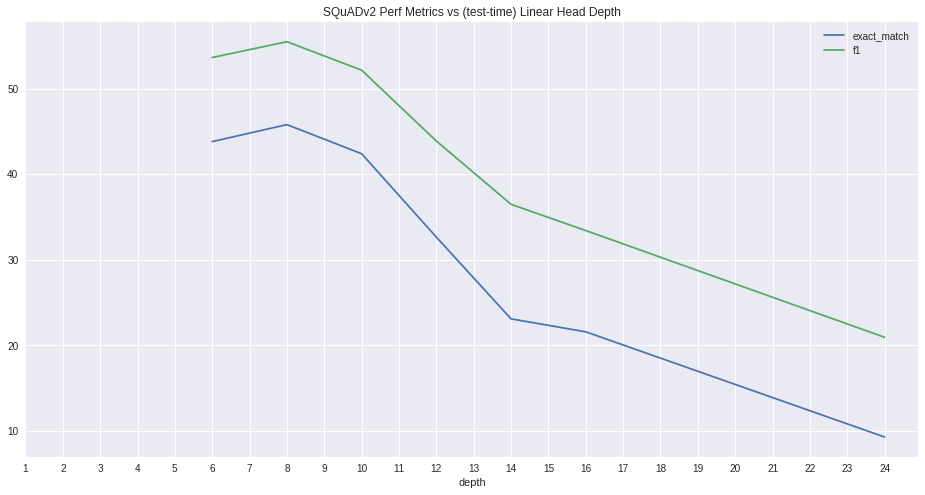

In [75]:
plot = df.plot(x='depth', title='SQuADv2 Perf Metrics vs (test-time) Linear Head Depth', figsize=(16,8))
plot.set_xticks(range(1,25))

In [76]:
plot.get_figure().savefig('saved_results_plot.png', dpi=300)  

In [77]:
# results = [
#  {'d': 6,
#   'exact': 20.121283584603724,
#   'f1': 28.163595174086794,
#   'total': 11873,
#   'HasAns_exact': 39.91228070175438,
#   'HasAns_f1': 56.01996718993465,
#   'HasAns_total': 5928,
#   'NoAns_exact': 0.3868797308662742,
#   'NoAns_f1': 0.3868797308662742,
#   'NoAns_total': 5945,
#   'best_exact': 50.09685841825992,
#   'best_exact_thresh': 0.0,
#   'best_f1': 50.1015231715139,
#   'best_f1_thresh': 0.0},
#  {'d': 8,
#   'exact': 20.121283584603724,
#   'f1': 28.163595174086794,
#   'total': 11873,
#   'HasAns_exact': 39.91228070175438,
#   'HasAns_f1': 56.01996718993465,
#   'HasAns_total': 5928,
#   'NoAns_exact': 0.3868797308662742,
#   'NoAns_f1': 0.3868797308662742,
#   'NoAns_total': 5945,
#   'best_exact': 50.09685841825992,
#   'best_exact_thresh': 0.0,
#   'best_f1': 50.1015231715139,
#   'best_f1_thresh': 0.0},
#  {'d': 12,
#   'exact': 76.74555714646678,
#   'f1': 79.68056866081807,
#   'total': 11873,
#   'HasAns_exact': 68.03306342780027,
#   'HasAns_f1': 73.91150332488064,
#   'HasAns_total': 5928,
#   'NoAns_exact': 85.43313708999159,
#   'NoAns_f1': 85.43313708999159,
#   'NoAns_total': 5945,
#   'best_exact': 76.7539796176198,
#   'best_exact_thresh': 0.0,
#   'best_f1': 79.68899113197111,
#   'best_f1_thresh': 0.0},
#  {'d': 16,
#   'exact': 63.56438979196496,
#   'f1': 68.55612565575909,
#   'total': 11873,
#   'HasAns_exact': 60.57692307692308,
#   'HasAns_f1': 70.57470983650869,
#   'HasAns_total': 5928,
#   'NoAns_exact': 66.54331370899916,
#   'NoAns_f1': 66.54331370899916,
#   'NoAns_total': 5945,
#   'best_exact': 63.572812263117996,
#   'best_exact_thresh': 0.0,
#   'best_f1': 68.5645481269126,
#   'best_f1_thresh': 0.0},
#   {'d': 18,
#   'exact': 63.56438979196496,
#   'f1': 68.55612565575909,
#   'total': 11873,
#   'HasAns_exact': 60.57692307692308,
#   'HasAns_f1': 70.57470983650869,
#   'HasAns_total': 5928,
#   'NoAns_exact': 66.54331370899916,
#   'NoAns_f1': 66.54331370899916,
#   'NoAns_total': 5945,
#   'best_exact': 63.572812263117996,
#   'best_exact_thresh': 0.0,
#   'best_f1': 68.5645481269126,
#   'best_f1_thresh': 0.0}
# ]